# [Module 3.5] AutoGluon Tabular with SageMaker

아래 노트북은 Bring Your Own Container(BYOC)를 구현 했습니다.**아래 공식 예제와 코드를 데이터를 제외하고 거의 같습니다.** 여러분도 데이터만 교체하여 사용하실 수 있습니다.


- AutoGluon Bring Your Own Container (BYOC) 예제
    - https://github.com/aws/amazon-sagemaker-examples/tree/master/advanced_functionality/autogluon-tabular
- AutoGluon 공식 Lab Git 
    - [AutoGluon](https://github.com/awslabs/autogluon) 
    
    
**편읙상 원본의 영문으로 된 것을 그대로 사용하고, 필요시에 한글로 설명이 있습니다.** 

##### 이 노트북은 소요 시간이 약 30 분 걸립니다.

#### 다커에 익숙지 않으신 분은 아래를 확인 해주세요.
- Hello docker (for 데이터 과학자 및 개발자 by 강성문)
- https://github.com/mullue/hello-docker/blob/master/hello_docker.ipynb

## Prerequisites

If using a SageMaker hosted notebook, select kernel `conda_mxnet_p36`.

In [1]:
# Make sure docker compose is set up properly for local mode
!./setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [2]:
import os
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

# Account/s3 setup
session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = 'sagemaker/autogluon-tabular'
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
    )
account = client.get_caller_identity()['Account']

registry_uri_training = sagemaker.image_uris.retrieve('mxnet', region, version= '1.6.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='training')
registry_uri_inference = sagemaker.image_uris.retrieve('mxnet', region, version= '1.6.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='inference')
ecr_uri_prefix = account +'.'+'.'.join(registry_uri_training.split('/')[0].split('.')[1:])

### Build docker images

Build the training/inference image and push to ECR

In [3]:
training_algorithm_name = 'autogluon-sagemaker-training-pdt'
inference_algorithm_name = 'autogluon-sagemaker-inference-pdt'

In [4]:
print("##### Build Training Image ###########")
!/bin/bash ./container-training/build_push_training.sh {account} {region} {training_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_training}
print("##### Build Inference Image ###########")
!/bin/bash ./container-inference/build_push_inference.sh {account} {region} {inference_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_inference}

##### Build Training Image ###########
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  14.61GB
Step 1/12 : ARG REGISTRY_URI
Step 2/12 : FROM ${REGISTRY_URI}
 ---> 148136370d72
Step 3/12 : RUN pip install autogluon
 ---> Using cache
 ---> 736b04ccce0b
Step 4/12 : RUN pip install PrettyTable
 ---> Using cache
 ---> a79327219225
Step 5/12 : RUN pip install bokeh
 ---> Using cach

### 데이터 로딩

기존에 만든 데이터를 로딩하고 합니다. AutoGluon 이용시 별도의 검증(validation)셋의 생성은 필요하지 않습니다. (내부적으로 k-fold cross-validation을 이용합니다.)


In [5]:
%store -r no_auto_train_file
%store -r no_auto_test_file

train = pd.read_csv(no_auto_train_file)
test = pd.read_csv(no_auto_test_file)

# Split test X/y
label = 'classes'
y_test = test[label]
X_test = test.drop(columns=[label])
print("auto_train_file: ", train.shape)
print("auto_train_file: ", test.shape)



from IPython.display import display as dp
dp(train.head(2))
dp(test.head(2))
dp(X_test.head(2))




auto_train_file:  (53740, 18)
auto_train_file:  (13436, 18)


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,12030,taubate,SP,29.99,10.96,9000.0,fashion_shoes,13481,limeira,SP,1,4,10,SP_SP,taubate_limeira,12030_13481,2640.0
1,2,78075,cuiaba,MT,23.90,26.82,1500.0,furniture_decor,17051,bauru,SP,1,4,10,MT_SP,cuiaba_bauru,78075_17051,14625.0


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,0,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


Upload the data to s3

In [6]:
from p_utils import upload_s3

# Upload train. test file
data_prefix = 'autogluon/predict-deliver-time/data'

train_s3_path = upload_s3(bucket, no_auto_train_file, data_prefix)
test_s3_path = upload_s3(bucket, no_auto_test_file, data_prefix)
print("train_s3_path: ", train_s3_path)
print("test_s3_path: ", test_s3_path)

train_s3_path:  s3://sagemaker-ap-northeast-2-057716757052/autogluon/predict-deliver-time/data/preproc_data/auto_no_fe/train/train.csv
test_s3_path:  s3://sagemaker-ap-northeast-2-057716757052/autogluon/predict-deliver-time/data/preproc_data/auto_no_fe/test/test.csv


In [7]:
# train_file = 'train.csv'
# train.to_csv(train_file,index=False)
# train_s3_path = session.upload_data(train_file, key_prefix='{}/data'.format(prefix))

# test_file = 'test.csv'
# test.to_csv(test_file,index=False)
# test_s3_path = session.upload_data(test_file, key_prefix='{}/data'.format(prefix))

# X_test_file = 'X_test.csv'
# X_test.to_csv(X_test_file,index=False)
# X_test_s3_path = session.upload_data(X_test_file, key_prefix='{}/data'.format(prefix))

## 하이퍼 파라미터를 설정 
실제 훈련을 하기 전에 훈련 이미지에 (훈련 코드 + 프레임워크 (MXNET, AutoGluon)) 파리미터를 제공 합니다. 
- 가장 중요한 파라미터는 아래와 같습니다.
    - label에 현재 데이터 셋의 레이블 컬럼을 입력해야 합니다.
    - presets은 모델이 '배포에 최적화' 하도록 파라미터 값을 제공 합니다. 
    - feature_importance: 추론후에 피쳐의 중요성을 프린트 합니다. (훈련 로그 참조)
```
fit_args = {
  'label': 'classes',
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}
hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}
```

## Hyperparameter Selection

The minimum required settings for training is just a target label, `fit_args['label']`.

Additional optional hyperparameters can be passed to the `autogluon.task.TabularPrediction.fit` function via `fit_args`.

Below shows a more in depth example of AutoGluon-Tabular hyperparameters from the example [Predicting Columns in a Table - In Depth](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-indepth.html#model-ensembling-with-stacking-bagging). Please see [fit parameters](https://autogluon.mxnet.io/api/autogluon.task.html?highlight=eval_metric#autogluon.task.TabularPrediction.fit) for further information. Note that in order for hyperparameter ranges to work in SageMaker, values passed to the `fit_args['hyperparameters']` must be represented as strings.

```python
nn_options = {
    'num_epochs': "10",
    'learning_rate': "ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)",
    'activation': "ag.space.Categorical('relu', 'softrelu', 'tanh')",
    'layers': "ag.space.Categorical([100],[1000],[200,100],[300,200,100])",
    'dropout_prob': "ag.space.Real(0.0, 0.5, default=0.1)"
}

gbm_options = {
    'num_boost_round': "100",
    'num_leaves': "ag.space.Int(lower=26, upper=66, default=36)"
}

model_hps = {'NN': nn_options, 'GBM': gbm_options} 

fit_args = {
  'label': 'y',
  'presets': ['best_quality', 'optimize_for_deployment'],
  'time_limits': 60*10,
  'hyperparameters': model_hps,
  'hyperparameter_tune': True,
  'search_strategy': 'skopt'
}

hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}
```
**Note:** Your hyperparameter choices may affect the size of the model package, which could result in additional time taken to upload your model and complete training. Including `'optimize_for_deployment'` in the list of `fit_args['presets']` is recommended to greatly reduce upload times.

<br>

In [8]:
# Define required label and optional additional parameters
fit_args = {
  'label': 'classes',
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}

# Pass fit_args to SageMaker estimator hyperparameters
hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}

tags = [{
    'Key' : 'AlgorithmName',
    'Value' : 'AutoGluon-Tabular'
}]

## 훈련
훈련에는 로컬 모드와 세이지 메이커의 클라우드 클러스터에서 실행할 수 있습니다. 처음 실행시에는 **로컬 모드** 를 사용 하세요. 시간이 절약 됩니다.
## Train 

For local training set `train_instance_type` to `local` .   
For non-local training the recommended instance type is `ml.m5.2xlarge`.   

**Note:** Depending on how many underlying models are trained, `train_volume_size` may need to be increased so that they all fit on disk.

In [9]:
%%time

instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

ecr_image = f'{ecr_uri_prefix}/{training_algorithm_name}:latest'

estimator = Estimator(image_uri=ecr_image,
                      role=role,
                      instance_count=1,
                      instance_type=instance_type,
                      hyperparameters=hyperparameters,
                      volume_size=100,
                      tags=tags)

# Set inputs. Test data is optional, but requires a label column.
inputs = {'training': train_s3_path, 'testing': test_s3_path}



CPU times: user 40.1 ms, sys: 3.95 ms, total: 44.1 ms
Wall time: 1.05 s


In [10]:
%%time
estimator.fit(inputs)

2020-11-17 09:19:09 Starting - Starting the training job...
2020-11-17 09:19:12 Starting - Launching requested ML instances......
2020-11-17 09:20:34 Starting - Preparing the instances for training......
2020-11-17 09:21:37 Downloading - Downloading input data
2020-11-17 09:21:37 Training - Downloading the training image.........
2020-11-17 09:22:57 Training - Training image download completed. Training in progress.2020-11-17 09:22:57,164 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2020-11-17 09:22:57,167 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-17 09:22:57,167 sagemaker-training-toolkit INFO     Failed to parse hyperparameter fit_args value {'label': 'classes', 'presets': ['optimize_for_deployment']} to Json.
Returning the value itself
2020-11-17 09:22:57,167 sagemaker-training-toolkit INFO     Failed to parse hyperparameter feature_importance value True to Json.
Returning the value itself


### Review the performance of the trained model

In [11]:
from utils.ag_utils import launch_viewer

In [12]:
from utils.ag_utils import launch_viewer

launch_viewer(is_debug=False)

HTML(value="<b><font size=4 color='#0000ff'>Please choose one training job from the list</font></b>")

### Create Model

In [13]:
# Create predictor object
class AutoGluonTabularPredictor(Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         serializer=CSVSerializer(), 
                         deserializer=StringDeserializer(), **kwargs)

In [14]:
ecr_image = f'{ecr_uri_prefix}/{inference_algorithm_name}:latest'

if instance_type == 'local':
    model = estimator.create_model(image_uri=ecr_image, role=role)
else:
    model_uri = os.path.join(estimator.output_path, estimator._current_job_name, "output", "model.tar.gz")
    model = Model(ecr_image, model_data=model_uri, role=role, sagemaker_session=session, predictor_cls=AutoGluonTabularPredictor)

### Batch Transform

For local mode, either `s3://<bucket>/<prefix>/output/` or `file:///<absolute_local_path>` can be used as outputs.

By including the label column in the test data, you can also evaluate prediction performance (In this case, passing `test_s3_path` instead of `X_test_s3_path`).

In [15]:
output_path = f's3://{bucket}/{prefix}/output/'
print("output_path: ", output_path)

transformer = model.transformer(instance_count=1, 
                                instance_type=instance_type,
                                strategy='MultiRecord',
                                max_payload=6,
                                max_concurrent_transforms=1,                              
                                output_path=output_path)

transformer.transform(test_s3_path, content_type='text/csv', split_type='Line')
transformer.wait()

output_path:  s3://sagemaker-ap-northeast-2-057716757052/sagemaker/autogluon-tabular/output/
2020-11-17 09:39:39,836 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 6215 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 8
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Preload model: false
Prefer direct buffer: false
2020-11-17 09:39:39,902 [WARN ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerLifeCycle - attachIOStreams() threadName=W-9000-model
2020-11-17 09:39:40,019 [INFO ] W-9000-model-stdout com.amazonaws.ml.mms.wlm.Wor

In [16]:
output_path

's3://sagemaker-ap-northeast-2-057716757052/sagemaker/autogluon-tabular/output/'

In [27]:
!aws s3 ls {output_path}
!aws s3 cp {output_path} . --recursive

2020-11-17 09:40:19      26872 test.csv.out
download: s3://sagemaker-ap-northeast-2-057716757052/sagemaker/autogluon-tabular/output/test.csv.out to ./test.csv.out


In [28]:
! head -n5 test.csv.out

2
2
2
2
2


### Endpoint

##### Deploy remote or local endpoint

In [17]:
instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

predictor = model.deploy(initial_instance_count=1, 
                         instance_type=instance_type)

---------------!

##### Attach to endpoint (or reattach if kernel was restarted)

In [18]:
# Select standard or local session based on instance_type
if instance_type == 'local': 
    sess = local_session
else: 
    sess = session

# Attach to endpoint
predictor = AutoGluonTabularPredictor(predictor.endpoint, sagemaker_session=sess)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


##### Predict on unlabeled test data

In [19]:
results = predictor.predict(X_test.to_csv(index=False)).splitlines()

# Check output
print(Counter(results))

Counter({'2': 5510, '3': 3534, '1': 2007, '0': 1266, '4': 1119})


##### Predict on data that includes label column  
Prediction performance metrics will be printed to endpoint logs.

In [20]:
results = predictor.predict(test.to_csv(index=False)).splitlines()

# Check output
print(Counter(results))

Counter({'2': 5510, '3': 3534, '1': 2007, '0': 1266, '4': 1119})


##### Check that classification performance metrics match evaluation printed to endpoint logs as expected

In [21]:
y_results = list(map(int, results)) # Convert String to int

In [22]:
# y_results = np.array(results)

print("accuracy: {}".format(accuracy_score(y_true=y_test, y_pred=y_results)))
print(classification_report(y_true=y_test, y_pred=y_results, digits=6))

accuracy: 0.4285501637392081
              precision    recall  f1-score   support

           0   0.629542  0.467449  0.536520      1705
           1   0.544594  0.262614  0.354352      4162
           2   0.439564  0.534068  0.482230      4535
           3   0.327108  0.533210  0.405472      2168
           4   0.259160  0.334873  0.292191       866

    accuracy                       0.428550     13436
   macro avg   0.439994  0.426443  0.414153     13436
weighted avg   0.466433  0.428550  0.424873     13436



<Figure size 432x288 with 0 Axes>

[[ 797  462  418   25    3]
 [ 258 1093 1809  904   98]
 [ 150  293 2422 1185  485]
 [  47  117  605 1156  243]
 [  14   42  256  264  290]]


<Figure size 432x288 with 0 Axes>

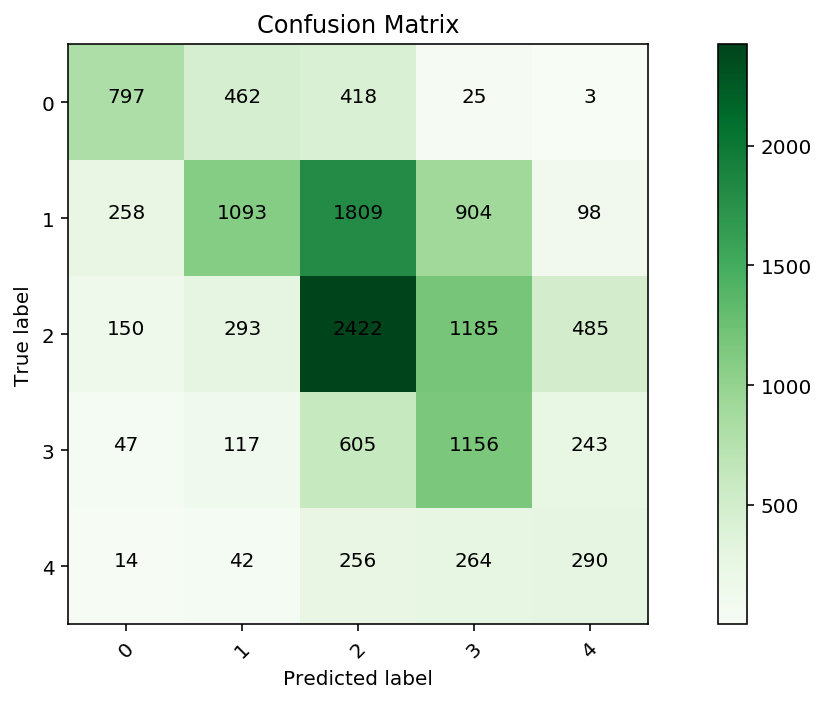

In [23]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= y_results)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

##### Clean up endpoint

In [24]:
predictor.delete_endpoint()